In [1]:
import numpy as np
import pandas as pd
import math
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Master Data Sets.ipynb")
from matplotlib import pyplot as plt
from ast import literal_eval
from sklearn.metrics.pairwise import haversine_distances
import itertools
from matplotlib import style
style.use('ggplot')
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [2]:
train_cust =pd.read_csv('train_customers.csv',parse_dates=['created_at','updated_at'])
test_cust =pd.read_csv('test_customers.csv',parse_dates=['created_at','updated_at'])
train_loc =pd.read_csv('train_locations.csv')
test_loc =pd.read_csv('test_locations.csv')
vendors =pd.read_csv('vendors.csv',parse_dates=['created_at','updated_at'])
orders =pd.read_csv('orders.csv',parse_dates=['created_at','delivery_date'])
submission =pd.read_csv('SampleSubmission.csv')
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", 200)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
train_cust= train_cust.rename({'akeed_customer_id': 'customer_id'}, axis=1)
test_cust= test_cust.rename({'akeed_customer_id': 'customer_id'}, axis=1)

In [4]:
test_cust = test_cust.drop_duplicates(subset='customer_id', keep="first")
train_cust = train_cust.drop_duplicates(subset='customer_id', keep="first")

In [5]:
'''


####.     HAVERSINE DISTANCE EQUATION FUNCTION      ####


'''

def haversine(lat1, lon1, lat2, lon2,to_radians=True, earth_radius=6371):
    

    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    
    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


In [6]:
dist1=train_loc[['customer_id','location_number','latitude','longitude']]
dist2=vendors[['id','latitude','longitude']]
dist=dist1.assign(key=1).merge(dist2.assign(key=1), on='key').drop('key',axis=1)

In [7]:
'''

        USING THE HAVERSINE FUNCTION TO FIND LAT-LONG DISTANCE FOR "TRAIN CUSTOMERS ~35,000"


'''
dist['distance'] = \
    haversine(dist['latitude_x'], dist['longitude_x'], dist['latitude_y'], dist['longitude_y'])

In [8]:
dist

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance
0,02SFNJH,0,1.682392,-78.789737,4,-0.588596,0.754434,8847.430953
1,02SFNJH,0,1.682392,-78.789737,13,-0.471654,0.744470,8845.913268
2,02SFNJH,0,1.682392,-78.789737,20,-0.407527,0.643681,8834.488717
3,02SFNJH,0,1.682392,-78.789737,23,-0.585385,0.753811,8847.350413
4,02SFNJH,0,1.682392,-78.789737,28,0.480602,0.552850,8821.455686
...,...,...,...,...,...,...,...,...
5950295,HWELAU8,1,-0.067043,0.648221,849,-1.588060,-0.066441,186.863629
5950296,HWELAU8,1,-0.067043,0.648221,855,2.145206,0.745025,246.226148
5950297,HWELAU8,1,-0.067043,0.648221,856,0.251469,0.483632,39.866058
5950298,HWELAU8,1,-0.067043,0.648221,858,0.019817,0.587087,11.810814


In [9]:
dist_des=dist['distance'].value_counts().rename_axis('distance').reset_index(name='counts')
dist_des.sort_values(by='distance', ascending=True)

,distance,counts
3979360,5.382287e-12,1
2704363,7.183735e-12,1
4519644,1.613687e-11,1
5474538,2.648213e-03,1
4451112,1.369540e-02,1
...,...,...
3538040,1.577797e+04,1
1771823,1.577803e+04,1
1446600,1.578530e+04,1
4866320,1.588988e+04,1


In [10]:
tdist1=test_loc[['customer_id','location_number','latitude','longitude']]
tdist2=vendors[['id','latitude','longitude']]
tdist=tdist1.assign(key=1).merge(tdist2.assign(key=1), on='key').drop('key',axis=1)

In [11]:
'''

        USING THE HAVERSINE FUNCTION TO FIND LAT-LONG DISTANCE FOR "TEST CUSTOMERS ~10,000"


'''
tdist['distance'] = \
    haversine(tdist['latitude_x'], tdist['longitude_x'], tdist['latitude_y'], tdist['longitude_y'])

In [12]:
tdist_des=tdist['distance'].value_counts().rename_axis('distance').reset_index(name='counts')
tdist_des.sort_values(by='distance', ascending=True)

,distance,counts
1663652,0.000000,1
7128,0.021050,1
385682,0.027751,1
1569946,0.033802,1
851041,0.043896,1
...,...,...
759370,18349.563448,1
1108008,18354.604178,1
1231557,18356.732460,1
170488,18357.324619,1


In [13]:
dist.sort_values(by='distance', ascending=True)

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance
4702470,ADL2P50,1,0.005748,0.482281,303,0.005748,0.482281,5.382287e-12
2976788,ZGFSYCZ,13,-0.116173,0.570707,676,-0.116173,0.570707,7.183735e-12
4412682,VVWLRL0,0,2.015615,0.749220,573,2.015615,0.749220,1.613687e-11
2799742,3CJKSR9,6,-0.060056,0.652652,191,-0.060048,0.652630,2.648213e-03
5267974,3T31BBH,0,-1.002260,0.078609,386,-1.002137,0.078609,1.369540e-02
...,...,...,...,...,...,...,...,...
5919895,O0LALCF,0,NaN,NaN,849,-1.588060,-0.066441,NaN
5919896,O0LALCF,0,NaN,NaN,855,2.145206,0.745025,NaN
5919897,O0LALCF,0,NaN,NaN,856,0.251469,0.483632,NaN
5919898,O0LALCF,0,NaN,NaN,858,0.019817,0.587087,NaN


In [14]:
tdist

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance
0,Z59FTQD,0,126.032278,-9.106019,4,-0.588596,0.754434,14010.898478
1,Z59FTQD,0,126.032278,-9.106019,13,-0.471654,0.744470,13998.133826
2,Z59FTQD,0,126.032278,-9.106019,20,-0.407527,0.643681,13992.442453
3,Z59FTQD,0,126.032278,-9.106019,23,-0.585385,0.753811,14010.552771
4,Z59FTQD,0,126.032278,-9.106019,28,0.480602,0.552850,13895.649154
...,...,...,...,...,...,...,...,...
1671995,3O8LSR3,0,-0.188562,0.827181,849,-1.588060,-0.066441,184.627859
1671996,3O8LSR3,0,-0.188562,0.827181,855,2.145206,0.745025,259.663855
1671997,3O8LSR3,0,-0.188562,0.827181,856,0.251469,0.483632,62.075568
1671998,3O8LSR3,0,-0.188562,0.827181,858,0.019817,0.587087,35.350024


In [15]:
tdist.describe()

,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance
count,1.672000e+06,1.671700e+06,1.671700e+06,1.672000e+06,1.672000e+06,1.672000e+06,1.671700e+06
mean,7.211124e-01,2.514850e+00,-2.527078e+01,2.888400e+02,1.875505e+00,8.036817e-01,3.345561e+03
std,1.163812e+00,2.210502e+01,3.693628e+01,2.410855e+02,2.049760e+01,4.375816e+00,4.383914e+03
min,0.000000e+00,-6.716931e+02,-1.322045e+02,4.000000e+00,-1.787413e+00,-1.449556e+00,0.000000e+00
25%,0.000000e+00,-5.131760e-01,-7.852129e+01,1.057500e+02,-8.091241e-01,8.161790e-02,7.680899e+01
50%,0.000000e+00,-9.803306e-02,1.174529e-02,2.020000e+02,-4.934212e-01,5.271227e-01,1.541305e+02
75%,1.000000e+00,2.460748e-01,5.093179e-01,3.872500e+02,1.591538e-02,6.447635e-01,8.749934e+03
max,1.100000e+01,4.536538e+02,4.412195e+01,9.070000e+02,2.052423e+02,4.421081e+01,1.836332e+04


             distance  counts
0        10279.711965     158
1        10220.297073      79
2        10178.879759      79
3        10283.239255      79
4        10228.907706      79
...               ...     ...
5887884     95.772838       1
5887885   8807.555586       1
5887886     30.207838       1
5887887     14.161093       1
5887888    103.172499       1

[5887889 rows x 2 columns]


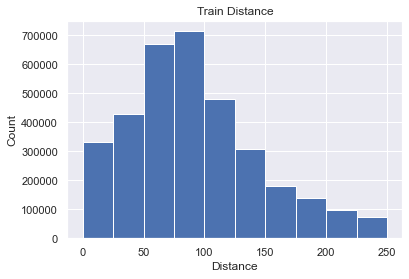

In [16]:
'''

        TRAIN CUSTOMER VENDOR DISTANCE DISTRIBUTION GRAPH.


'''
dist_des1=dist['distance'].value_counts().rename_axis('distance').reset_index(name='counts')
#dist_des1['%']=(dist_des1['counts']/5887889)*100
mean = np.mean(dist_des1['distance'])
sd = np.std(dist_des1['distance'])
dist_q = dist_des1[dist_des1['distance'] > mean - sd]
dist_q = dist_q[dist_q['distance'] < mean +  sd]
dist_q = dist_q[dist_q['distance'] < 250] 
dist_q.sort_values(by='distance', ascending=True)
x=dist_q['distance']
y=dist_q['counts']
plt.hist(x)
plt.grid=(True)
plt.title("Train Distance")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show
print(dist_des1)

             distance  counts
0        10279.711965      34
1        10212.924113      17
2        10204.615659      17
3        10283.239255      17
4        10268.174204      17
...               ...     ...
1663648    358.352159       1
1663649    166.326913       1
1663650   8726.308309       1
1663651    102.470665       1
1663652      0.000000       1

[1663653 rows x 2 columns]


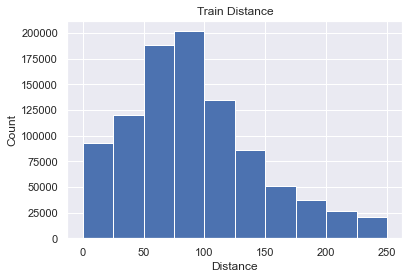

In [17]:
'''

        TEST CUSTOMER VENDOR DISTANCE DISTRIBUTION GRAPH.


'''
tdist_des1=tdist['distance'].value_counts().rename_axis('distance').reset_index(name='counts')
#tdist_des1['%']=(tdist_des1['counts']/1663653)*100
mean = np.mean(tdist_des1['distance'])
sd = np.std(tdist_des1['distance'])
tdist_q = tdist_des1[tdist_des1['distance'] > mean - sd]
tdist_q = tdist_q[tdist_q['distance'] < mean +  sd]
tdist_q = tdist_q[tdist_q['distance'] < 250] 
tdist_q.sort_values(by='distance', ascending=True)
x=tdist_q['distance']
y=tdist_q['counts']
plt.hist(x)
plt.grid=(True)
plt.title("Train Distance")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show
print(tdist_des1)

In [18]:
bin_list=[0,2,5,10,15,30,50,100,500,1000,5000,10000]

In [19]:
    dist4=dist[(dist['distance']>=(0))&(dist['distance']<=(5))]
    dist4=dist4['distance'].value_counts(bins=1).rename_axis('distance').reset_index(name='counts')
dist4

,distance,counts
0,"(-0.006, 5.0]",27961


In [20]:
'''

        BINNING AND FINDING FREQUENCY OF TRAIN CUSTOMER VENDOR DISTANCE.


'''
dist5=pd.DataFrame(columns=['distance','counts'])
list_cycle = itertools.cycle(bin_list)
next(list_cycle)
for i in range(0,11):
    g=bin_list[i]
    next_element = next(list_cycle)
    dist4=dist[(dist['distance']>=(g))&(dist['distance']<=(next_element))]
    dist4=dist4['distance'].value_counts(bins=1).rename_axis('distance').reset_index(name='counts')
    dist5=dist5.append(dist4)
dist4=dist[(dist['distance']>=10000)]
dist4=dist4['distance'].value_counts(bins=1).rename_axis('distance').reset_index(name='counts')
dist5=dist5.append(dist4)
dist5['%']=(dist5['counts']/5887889)*100
dist5.reset_index(inplace = True) 
dist5.drop(columns=['index'])
dist5=dist5.drop(columns=['index'])
dist5.at[11,'distance']= '>10000'
dist5

,distance,counts,%
0,"(-0.003, 2.0]",6039,0.102566
1,"(1.9960000000000002, 5.0]",21922,0.372324
2,"(4.994, 10.0]",58597,0.995212
3,"(9.994, 15.0]",78987,1.34152
4,"(14.984, 30.0]",250795,4.25951
5,"(29.979, 50.0]",345137,5.86181
6,"(49.949000000000005, 100.0]",1392079,23.6431
7,"(99.59899999999999, 499.975]",1521432,25.84
8,"(499.505, 998.871]",3053,0.0518522
9,"(998.1750000000001, 4998.39]",199212,3.38342


In [21]:
'''

        BINNING AND FINDING FREQUENCY OF TEST CUSTOMER VENDOR DISTANCE.


'''
tdist5=pd.DataFrame(columns=['distance','counts'])
list_cycle = itertools.cycle(bin_list)
next(list_cycle)
for i in range(0,11):
    g=bin_list[i]
    next_element = next(list_cycle)
    tdist4=tdist[(tdist['distance']>=(g))&(tdist['distance']<=(next_element))]
    tdist4=tdist4['distance'].value_counts(bins=1).rename_axis('distance').reset_index(name='counts')
    tdist5=tdist5.append(tdist4)
tdist4=tdist[(tdist['distance']>=10000)]
tdist4=tdist4['distance'].value_counts(bins=1).rename_axis('distance').reset_index(name='counts')
tdist5=tdist5.append(tdist4)
tdist5['%']=(tdist5['counts']/1663653)*100
tdist5.reset_index(inplace = True) 
tdist5=tdist5.drop(columns=['index'])
tdist5.at[11,'distance']= '>10000'
tdist5

,distance,counts,%
0,"(-0.003, 1.999]",1718,0.103267
1,"(1.997, 4.999]",5984,0.35969
2,"(4.994, 10.0]",16491,0.991252
3,"(9.994, 15.0]",21795,1.31007
4,"(14.984, 30.0]",70201,4.21969
5,"(29.979, 50.0]",96350,5.79147
6,"(49.949000000000005, 100.0]",391535,23.5347
7,"(99.59899999999999, 499.98]",423371,25.4483
8,"(499.596, 954.567]",1086,0.065278
9,"(1018.5640000000001, 3362.632]",56237,3.38033


In [22]:
dist

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance
0,02SFNJH,0,1.682392,-78.789737,4,-0.588596,0.754434,8847.430953
1,02SFNJH,0,1.682392,-78.789737,13,-0.471654,0.744470,8845.913268
2,02SFNJH,0,1.682392,-78.789737,20,-0.407527,0.643681,8834.488717
3,02SFNJH,0,1.682392,-78.789737,23,-0.585385,0.753811,8847.350413
4,02SFNJH,0,1.682392,-78.789737,28,0.480602,0.552850,8821.455686
...,...,...,...,...,...,...,...,...
5950295,HWELAU8,1,-0.067043,0.648221,849,-1.588060,-0.066441,186.863629
5950296,HWELAU8,1,-0.067043,0.648221,855,2.145206,0.745025,246.226148
5950297,HWELAU8,1,-0.067043,0.648221,856,0.251469,0.483632,39.866058
5950298,HWELAU8,1,-0.067043,0.648221,858,0.019817,0.587087,11.810814


In [23]:
'''

        APPENDING DELIVERY DISTANCE FROM ORDER DATASET TO THE ABOVE "dist"(TRAIN CUST) TABLE.


'''
dist['location_number_obj']=dist['location_number'].astype(str)
tdist['location_number_obj']=tdist['location_number'].astype(str)
dist['id_obj']=dist['id'].astype(str)
tdist['id_obj']=tdist['id'].astype(str)

In [24]:
dist['CID X LOC_NUM X VENDOR'] = dist['customer_id'] +' X '+ dist['location_number_obj'] +' X '+ dist['id_obj']
tdist['CID X LOC_NUM X VENDOR'] = tdist['customer_id'] +' X '+ tdist['location_number_obj'] +' X '+ tdist['id_obj']

In [25]:
serv_dist=orders[['CID X LOC_NUM X VENDOR','deliverydistance']]
serv_dist=serv_dist.groupby('CID X LOC_NUM X VENDOR').mean().reset_index()

In [26]:
dist =pd.merge(dist, serv_dist, on ='CID X LOC_NUM X VENDOR', how ='left')
tdist =pd.merge(tdist, serv_dist, on ='CID X LOC_NUM X VENDOR', how ='left')


In [27]:
'''

        DOING AWAY WITH THE NULL VALUES IN DELIVERY DISTANCE TO GET ONLY THE COMBINATION OF TRAIN CUST AND
        VENDORS WHO HAVE PLACED ORDERS.


'''
dist_notn= dist[dist['deliverydistance'].notnull()]
dist_notn

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance,location_number_obj,id_obj,CID X LOC_NUM X VENDOR,deliverydistance
143,02SFNJH,1,1.679137,0.766823,192,1.703119,0.759958,2.773773,1,192,02SFNJH X 1 X 192,0.41
148,02SFNJH,1,1.679137,0.766823,199,2.337754,0.699575,73.615197,1,199,02SFNJH X 1 X 199,0.00
196,02SFNJH,1,1.679137,0.766823,855,2.145206,0.745025,51.881119,1,855,02SFNJH X 1 X 855,4.22
235,02SFNJH,2,-0.498648,0.661241,159,-0.599865,0.756244,15.435520,2,159,02SFNJH X 2 X 159,5.10
397,RU43CXC,0,0.100853,0.438165,856,0.251469,0.483632,17.494183,0,856,RU43CXC X 0 X 856,3.68
...,...,...,...,...,...,...,...,...,...,...,...,...
5950211,HWELAU8,1,-0.067043,0.648221,75,-0.600423,0.755909,60.505807,1,75,HWELAU8 X 1 X 75,6.84
5950240,HWELAU8,1,-0.067043,0.648221,188,-0.405660,0.644401,37.654916,1,188,HWELAU8 X 1 X 188,5.75
5950241,HWELAU8,1,-0.067043,0.648221,189,-0.856856,0.087738,107.688182,1,189,HWELAU8 X 1 X 189,0.00
5950259,HWELAU8,1,-0.067043,0.648221,259,0.025821,0.551594,14.902053,1,259,HWELAU8 X 1 X 259,6.37


In [28]:
dist5.reset_index(inplace = True) 
dist5.drop(columns=['index'])

,distance,counts,%
0,"(-0.003, 2.0]",6039,0.102566
1,"(1.9960000000000002, 5.0]",21922,0.372324
2,"(4.994, 10.0]",58597,0.995212
3,"(9.994, 15.0]",78987,1.34152
4,"(14.984, 30.0]",250795,4.25951
5,"(29.979, 50.0]",345137,5.86181
6,"(49.949000000000005, 100.0]",1392079,23.6431
7,"(99.59899999999999, 499.975]",1521432,25.84
8,"(499.505, 998.871]",3053,0.0518522
9,"(998.1750000000001, 4998.39]",199212,3.38342


In [29]:
'''

        APPENDING ORDER NUMBER, ORDER PERCENTAGE TO THE CUSTOMER VENDOR COMBINATION AND MEAN DELIVERY DISTANCE 
        TO THE ABOVE TABLE.


'''
o=[]
o1=[]
list_cycle = itertools.cycle(bin_list)
next(list_cycle)
for i in range(0,11):
    g=bin_list[i]
    next_element = next(list_cycle)
    dist4=dist[(dist['distance']>=(g))&(dist['distance']<=(next_element))]
    dist4=dist4[dist4['deliverydistance'].notnull()]
    o.append(len(dist4))
    temp = np.mean(dist4['deliverydistance'])
    o1.append(temp)
dist4=dist[(dist['distance']>=10000)]
dist4=dist4[dist4['deliverydistance'].notnull()]
o.append(len(dist4))
temp = np.mean(dist4['deliverydistance'])
o1.append(temp)
dist5['order_no']=o
dist5['order_%']=(dist5['order_no']/dist5['counts'])*100
dist5['delivery_dist_mean']=o1

In [30]:
o1

[1.35684204709432,
 1.9297861868526982,
 2.688790545622132,
 3.648549423865446,
 4.647401356968092,
 5.569161259467137,
 6.5303421183566215,
 7.204533692569265,
 0.0,
 0.0,
 0.0013973854550069806,
 0.09026455026455026]

In [31]:
dist5

,index,distance,counts,%,order_no,order_%,delivery_dist_mean
0,0,"(-0.003, 2.0]",6039,0.102566,330,5.46448,1.356842
1,1,"(1.9960000000000002, 5.0]",21922,0.372324,1334,6.08521,1.929786
2,2,"(4.994, 10.0]",58597,0.995212,2866,4.89104,2.688791
3,3,"(9.994, 15.0]",78987,1.34152,3224,4.08168,3.648549
4,4,"(14.984, 30.0]",250795,4.25951,9162,3.65318,4.647401
5,5,"(29.979, 50.0]",345137,5.86181,10163,2.94463,5.569161
6,6,"(49.949000000000005, 100.0]",1392079,23.6431,18888,1.35682,6.530342
7,7,"(99.59899999999999, 499.975]",1521432,25.84,10328,0.678834,7.204534
8,8,"(499.505, 998.871]",3053,0.0518522,12,0.393056,0.000000
9,9,"(998.1750000000001, 4998.39]",199212,3.38342,4,0.00200791,0.000000


<function matplotlib.pyplot.show(*args, **kw)>

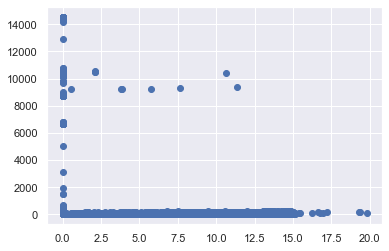

In [32]:
x=dist_notn['deliverydistance']
y=dist_notn['distance']
plt.scatter(x,y)
plt.show

In [33]:
dist_notn.describe()

,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance,deliverydistance
count,80142.000000,80137.000000,80137.000000,80142.000000,80142.000000,80142.000000,8.013700e+04,80142.000000
mean,0.839136,-0.095407,-22.975914,247.258441,1.036816,0.624916,2.655505e+03,3.986344
std,1.251256,7.517857,36.006437,230.270831,16.348097,3.494387,3.998608e+03,4.281229
min,0.000000,-671.738872,-134.415302,4.000000,-1.787413,-1.449556,7.183735e-12,0.000000
25%,0.000000,-0.442856,-78.509713,84.000000,-0.845096,0.080839,3.614478e+01,0.000000
50%,0.000000,-0.087130,0.011911,159.000000,-0.523719,0.482451,8.222786e+01,2.820000
75%,1.000000,0.178912,0.506170,304.000000,0.019817,0.605368,8.742081e+03,7.510000
max,25.000000,453.653846,44.108331,907.000000,205.242327,44.210807,1.455530e+04,19.810000


In [34]:
mean = np.mean(dist_notn['distance'])
sd = np.std(dist_notn['distance'])
print(mean)
print(sd)

2655.504918027568
3998.583274140622


In [35]:
'''

        FILTERING ONLY THOSE POINTS WITHIN ONE STANDARD DEVIATION FROM THE MEAN (68%) REST ARE CONSIDERED OUTLIERS 


'''
dist_f = dist_notn[dist_notn['distance'] > mean - sd]
dist_f = dist_f[dist_f['distance'] < mean +  sd]

In [36]:
dist_f 

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance,location_number_obj,id_obj,CID X LOC_NUM X VENDOR,deliverydistance
143,02SFNJH,1,1.679137,0.766823,192,1.703119,0.759958,2.773773,1,192,02SFNJH X 1 X 192,0.41
148,02SFNJH,1,1.679137,0.766823,199,2.337754,0.699575,73.615197,1,199,02SFNJH X 1 X 199,0.00
196,02SFNJH,1,1.679137,0.766823,855,2.145206,0.745025,51.881119,1,855,02SFNJH X 1 X 855,4.22
235,02SFNJH,2,-0.498648,0.661241,159,-0.599865,0.756244,15.435520,2,159,02SFNJH X 2 X 159,5.10
397,RU43CXC,0,0.100853,0.438165,856,0.251469,0.483632,17.494183,0,856,RU43CXC X 0 X 856,3.68
...,...,...,...,...,...,...,...,...,...,...,...,...
5950211,HWELAU8,1,-0.067043,0.648221,75,-0.600423,0.755909,60.505807,1,75,HWELAU8 X 1 X 75,6.84
5950240,HWELAU8,1,-0.067043,0.648221,188,-0.405660,0.644401,37.654916,1,188,HWELAU8 X 1 X 188,5.75
5950241,HWELAU8,1,-0.067043,0.648221,189,-0.856856,0.087738,107.688182,1,189,HWELAU8 X 1 X 189,0.00
5950259,HWELAU8,1,-0.067043,0.648221,259,0.025821,0.551594,14.902053,1,259,HWELAU8 X 1 X 259,6.37


<function matplotlib.pyplot.show(*args, **kw)>

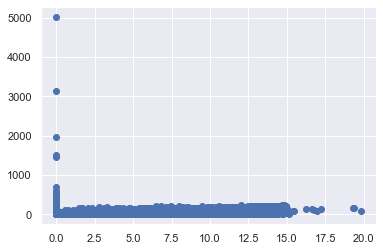

In [37]:
x=dist_f['deliverydistance']
y=dist_f['distance']
plt.scatter(x,y)
plt.show

In [38]:
'''

        FURTHER FILTERING OUT POINTS IN THE 0 DELIVERY DISTANCE WHICH ARE SKEWING THE GRAPH
        
'''
dist_f = dist_f[dist_f['distance'] < 250] 
dist_f = dist_f[dist_f['deliverydistance'] < 15]

<function matplotlib.pyplot.show(*args, **kw)>

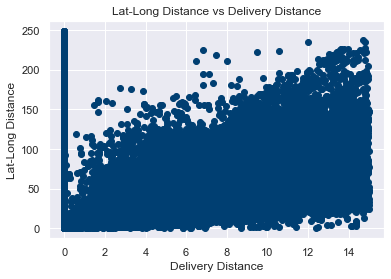

In [39]:
'''

        LAT-LONG DISTANCE VS DELIVERY DISTANCE GRAPH.


'''
x=dist_f['deliverydistance']
y=dist_f['distance']
plt.scatter(x,y,color='#003F72')
plt.title("Lat-Long Distance vs Delivery Distance")
plt.xlabel("Delivery Distance")
plt.ylabel("Lat-Long Distance")
plt.show

In [40]:
dist_f.shape

(55939, 12)

In [41]:
'''

        FINDING THE BEST FIT LINE.


'''
from statistics import mean
def best_fit_slope_and_intercept(x,y):
    m = (((mean(x)*mean(y)) - mean(x*y)) /
         ((mean(x)*mean(x)) - mean(x*x)))
    
    b = mean(y) - m*mean(x)
    
    return m, b

m, b = best_fit_slope_and_intercept(x,y)

print(m,b)

3.2163574575777694 40.901583679408965


In [42]:
regression_line = [(m*x)+b for x in x]

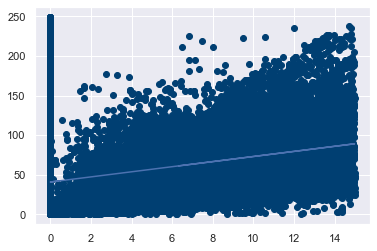

In [43]:
plt.scatter(x,y,color='#003F72')
plt.plot(x, regression_line)
plt.show()

In [44]:
dist_f

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance,location_number_obj,id_obj,CID X LOC_NUM X VENDOR,deliverydistance
143,02SFNJH,1,1.679137,0.766823,192,1.703119,0.759958,2.773773,1,192,02SFNJH X 1 X 192,0.41
148,02SFNJH,1,1.679137,0.766823,199,2.337754,0.699575,73.615197,1,199,02SFNJH X 1 X 199,0.00
196,02SFNJH,1,1.679137,0.766823,855,2.145206,0.745025,51.881119,1,855,02SFNJH X 1 X 855,4.22
235,02SFNJH,2,-0.498648,0.661241,159,-0.599865,0.756244,15.435520,2,159,02SFNJH X 2 X 159,5.10
397,RU43CXC,0,0.100853,0.438165,856,0.251469,0.483632,17.494183,0,856,RU43CXC X 0 X 856,3.68
...,...,...,...,...,...,...,...,...,...,...,...,...
5950211,HWELAU8,1,-0.067043,0.648221,75,-0.600423,0.755909,60.505807,1,75,HWELAU8 X 1 X 75,6.84
5950240,HWELAU8,1,-0.067043,0.648221,188,-0.405660,0.644401,37.654916,1,188,HWELAU8 X 1 X 188,5.75
5950241,HWELAU8,1,-0.067043,0.648221,189,-0.856856,0.087738,107.688182,1,189,HWELAU8 X 1 X 189,0.00
5950259,HWELAU8,1,-0.067043,0.648221,259,0.025821,0.551594,14.902053,1,259,HWELAU8 X 1 X 259,6.37


In [45]:

dist5

,index,distance,counts,%,order_no,order_%,delivery_dist_mean
0,0,"(-0.003, 2.0]",6039,0.102566,330,5.46448,1.356842
1,1,"(1.9960000000000002, 5.0]",21922,0.372324,1334,6.08521,1.929786
2,2,"(4.994, 10.0]",58597,0.995212,2866,4.89104,2.688791
3,3,"(9.994, 15.0]",78987,1.34152,3224,4.08168,3.648549
4,4,"(14.984, 30.0]",250795,4.25951,9162,3.65318,4.647401
5,5,"(29.979, 50.0]",345137,5.86181,10163,2.94463,5.569161
6,6,"(49.949000000000005, 100.0]",1392079,23.6431,18888,1.35682,6.530342
7,7,"(99.59899999999999, 499.975]",1521432,25.84,10328,0.678834,7.204534
8,8,"(499.505, 998.871]",3053,0.0518522,12,0.393056,0.000000
9,9,"(998.1750000000001, 4998.39]",199212,3.38342,4,0.00200791,0.000000


In [46]:
k=pd.Series(dist5['%'])

In [47]:
k.sum()

101.04979900266463

In [48]:
'''

        FINDING THE MEAN STD MIN AND MAX FOR THE DELIVERY DISTANCE.


'''
serv_dist=dist_f[['CID X LOC_NUM X VENDOR','deliverydistance']]
latlong_dist=dist_f[['CID X LOC_NUM X VENDOR','distance']]
latlong_dist1=latlong_dist.drop_duplicates(subset='CID X LOC_NUM X VENDOR', keep="first").reset_index()
serv_dist1=serv_dist.groupby('CID X LOC_NUM X VENDOR').mean().reset_index()
serv_dist1=serv_dist1.rename(columns={'deliverydistance':'mean'})
serv_dist2=serv_dist.groupby('CID X LOC_NUM X VENDOR').std().reset_index()
serv_dist2=serv_dist2.rename(columns={'deliverydistance':'std'})
serv_dist3=serv_dist.groupby('CID X LOC_NUM X VENDOR').min().reset_index()
serv_dist3=serv_dist3.rename(columns={'deliverydistance':'min'})
serv_dist4=serv_dist.groupby('CID X LOC_NUM X VENDOR').max().reset_index()
serv_dist4=serv_dist4.rename(columns={'deliverydistance':'max'})
serv_dist5=orders['CID X LOC_NUM X VENDOR'].value_counts().rename_axis('CID X LOC_NUM X VENDOR').reset_index(name='counts')
CLV_freq =pd.merge(latlong_dist1,serv_dist5, on ='CID X LOC_NUM X VENDOR', how ='left')
CLV_freq =pd.merge(CLV_freq,serv_dist1, on ='CID X LOC_NUM X VENDOR', how ='left')
CLV_freq =pd.merge(CLV_freq,serv_dist2, on ='CID X LOC_NUM X VENDOR', how ='left')
CLV_freq =pd.merge(CLV_freq,serv_dist3, on ='CID X LOC_NUM X VENDOR', how ='left')
CLV_freq =pd.merge(CLV_freq,serv_dist4, on ='CID X LOC_NUM X VENDOR', how ='left')
CLV_freq=CLV_freq.sort_values(by='counts', ascending=False).reset_index()
CLV_freq=CLV_freq.drop(columns=['index','level_0'])
CLV_freq

,CID X LOC_NUM X VENDOR,distance,counts,mean,std,min,max
0,XW90EAP X 3 X 13,17.813302,69,1.514493,NaN,1.514493,1.514493
1,KXXRD9J X 2 X 157,2.861194,62,1.351452,NaN,1.351452,1.351452
2,3W4JVGN X 1 X 303,8.282563,61,3.222295,NaN,3.222295,3.222295
3,A46KPEA X 1 X 157,47.962003,49,6.598980,NaN,6.598980,6.598980
4,HSKCXYG X 1 X 113,48.813177,46,6.524348,NaN,6.524348,6.524348
...,...,...,...,...,...,...,...
55934,RLC32ZB X 0 X 398,27.557423,1,14.240000,NaN,14.240000,14.240000
55935,RLC32ZB X 0 X 849,98.119466,1,7.260000,NaN,7.260000,7.260000
55936,2HT7RZV X 0 X 43,15.309429,1,3.750000,NaN,3.750000,3.750000
55937,YCHG7IM X 1 X 43,84.001018,1,9.430000,NaN,9.430000,9.430000


In [49]:
'''

        IT IS NOTICED THAT THERE IS NO DEVIAION OF DELIVERY DISTANCE FOR MULTIPLE ORDER, THERE IS CONSISTENCY
        IN DELIVERY DISTANCE FOR A CUSTOMER WHO IS ORDERING FROM THE SAME VENDOR MULTIPLE TIMES.


'''
serv_dist21=serv_dist2[serv_dist2['std'].notnull()]
serv_dist21

,CID X LOC_NUM X VENDOR,std


Text(0, 0.5, 'Latitude')

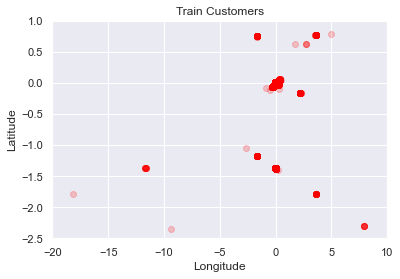

In [50]:
'''

        TRAIN CUSTOMERS LAT LONG PLOT

'''
trainLY=[np.radians(train_loc['longitude'])]
trainLX=[np.radians(train_loc['latitude'])]
plt.scatter(trainLX,trainLY, color="red", alpha=0.2)
plt.xlim(-20,10)
plt.ylim(-2.5,1)
plt.title("Train Customers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Text(0, 0.5, 'Latitude')

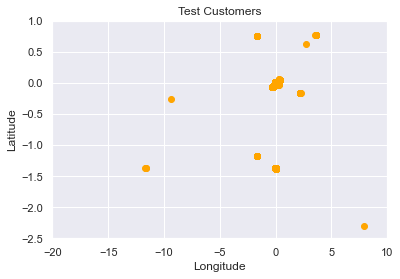

In [51]:
'''

        TEST CUSTOMERS LAT LONG PLOT

'''
testLY=[np.radians(test_loc['longitude'])]
testLX=[np.radians(test_loc['latitude'])]
plt.scatter(testLX,testLY, color="orange")
plt.xlim(-20,10)
plt.ylim(-2.5,1)
plt.title("Test Customers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Text(0, 0.5, 'Latitude')

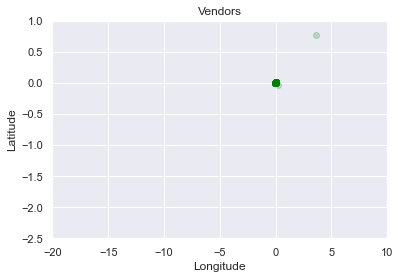

In [52]:
'''

        VENDORS LAT LONG PLOT

'''
venLY=[np.radians(vendors['longitude'])]
venLX=[np.radians(vendors['latitude'])]
plt.scatter(venLX,venLY, color="green", alpha=0.2)
plt.xlim(-20,10)
plt.ylim(-2.5,1)
plt.title("Vendors")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Text(0, 0.5, 'Latitude')

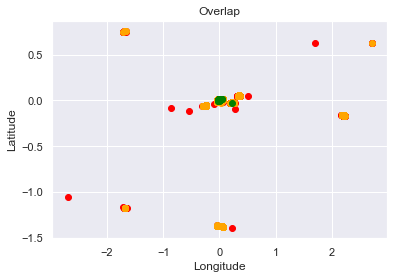

In [53]:
'''

        OVERLAPING LAT LONG PLOT ALSO FILTERING OUT OUTLIERS ABOVE THE LAT LONG LIMIT

'''
train_loc1=train_loc[(train_loc['latitude']>-180) & (train_loc['latitude']< 180) & (train_loc['longitude']>-90) & (train_loc['longitude']<90)]
test_loc1=test_loc[(test_loc['latitude']>-180) & (test_loc['latitude']< 180) & (test_loc['longitude']>-90) & (test_loc['longitude']<90)]
vendors1=vendors[(vendors['latitude']>-180) & (vendors['latitude']< 180) & (vendors['longitude']>-90) & (vendors['longitude']<90)]



trainLY=[np.radians(train_loc1['longitude'])]
trainLX=[np.radians(train_loc1['latitude'])]
plt.scatter(trainLX,trainLY, color="red")

testLY=[np.radians(test_loc1['longitude'])]
testLX=[np.radians(test_loc1['latitude'])]
plt.scatter(testLX,testLY, color="orange")




venLY=[np.radians(vendors1['longitude'])]
venLX=[np.radians(vendors1['latitude'])]
plt.scatter(venLX,venLY, color="green")

plt.title("Overlap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [251]:
train_ll=train_loc[['customer_id','latitude','longitude','location_number']]
test_ll=test_loc[['customer_id','latitude','longitude','location_number']]

In [252]:
train_ll=train_ll[(train_ll['latitude'].notnull())&(train_ll['longitude'].notnull())]
test_ll=test_ll[(test_ll['latitude'].notnull())&(test_ll['longitude'].notnull())]
train_ll['location_number_obj']=train_ll['location_number'].astype(str)
test_ll['location_number_obj']=test_ll['location_number'].astype(str)
train_ll['CID X LOC_NUM'] = train_ll['customer_id'] +' X '+ train_ll['location_number_obj']
test_ll['CID X LOC_NUM'] = test_ll['customer_id'] +' X '+ test_ll['location_number_obj']
train_ll=train_ll.drop(columns=['location_number_obj'])
test_ll=test_ll.drop(columns=['location_number_obj'])

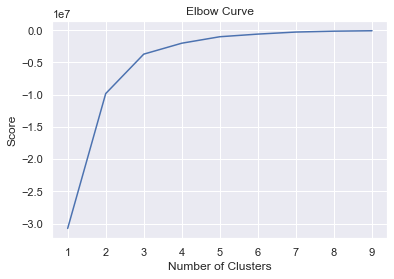

In [253]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = train_ll[['latitude']]
X_axis = train_ll[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

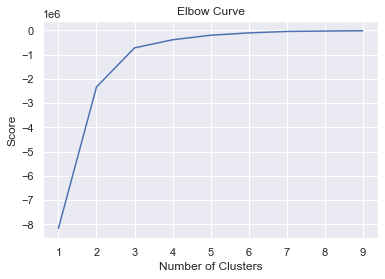

In [254]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = test_ll[['latitude']]
X_axis = test_ll[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

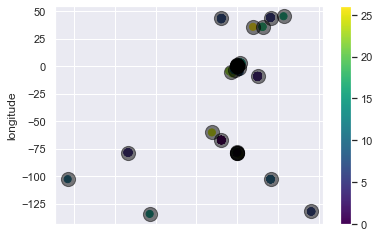

In [255]:
kmeans = KMeans(n_clusters = 27, init ='k-means++')
kmeans.fit(train_ll[train_ll.columns[1:3]]) # Compute k-means clustering.
train_ll['cluster_label'] = kmeans.fit_predict(train_ll[train_ll.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(train_ll[train_ll.columns[1:3]]) # Labels of each point
train_ll.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [256]:
centers

array([[-9.63605528e+01, -6.72028438e+01],
       [-1.62800786e+00, -1.25927554e-01],
       [-1.62128664e-03, -7.85907175e+01],
       [ 1.25990914e+02, -9.21892744e+00],
       [-6.68007920e+02, -7.85729532e+01],
       [ 2.04771505e+02,  4.40972693e+01],
       [ 4.53653846e+02, -1.32204545e+02],
       [-9.64737631e+01,  4.35090397e+01],
       [ 1.29732475e+01, -1.42942424e+00],
       [ 2.04869938e+02, -1.02802811e+02],
       [-1.03814929e+03, -1.02794092e+02],
       [-7.90036114e-01,  1.35500715e-01],
       [-1.50382197e+01, -3.35195034e+00],
       [ 5.83690884e-01,  4.99859071e-01],
       [-5.35818578e+02, -1.34415302e+02],
       [ 1.96045639e+01,  3.02535168e+00],
       [ 2.84341461e+02,  4.53542311e+01],
       [ 1.55538695e+02,  3.57727427e+01],
       [ 2.06527439e+00,  6.64164211e-01],
       [-8.17243429e-01, -7.84943258e+01],
       [ 8.23869392e-01, -7.86882755e+01],
       [-1.51509016e-01,  6.02829614e-01],
       [-4.02169383e+01, -5.60101065e+00],
       [ 2.

In [257]:
'''
kmeans = KMeans(n_clusters = 8, init ='k-means++')
kmeans.fit(test_ll[test_ll.columns[1:3]]) # Compute k-means clustering.
test_ll['cluster_label'] = kmeans.fit_predict(test_ll[test_ll.columns[1:3]])
tcenters = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(test_ll[test_ll.columns[1:3]]) # Labels of each point
test_ll.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(tcenters[:, 0], tcenters[:, 1], c='black', s=200, alpha=0)
'''

"\nkmeans = KMeans(n_clusters = 8, init ='k-means++')\nkmeans.fit(test_ll[test_ll.columns[1:3]]) # Compute k-means clustering.\ntest_ll['cluster_label'] = kmeans.fit_predict(test_ll[test_ll.columns[1:3]])\ntcenters = kmeans.cluster_centers_ # Coordinates of cluster centers.\nlabels = kmeans.predict(test_ll[test_ll.columns[1:3]]) # Labels of each point\ntest_ll.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')\nplt.scatter(tcenters[:, 0], tcenters[:, 1], c='black', s=200, alpha=0)\n"

In [258]:
centers_d=pd.DataFrame(centers,columns=['latitude','longitude'])
centers_d=centers_d.reset_index()
centers_d.iloc[2]

index         2.000000
latitude     -0.001621
longitude   -78.590717
Name: 2, dtype: float64

In [259]:
test_ll=test_ll.assign(key=1).merge(centers_d.assign(key=1), on='key').drop('key',axis=1)
test_ll['distance'] = \
    haversine(test_ll['latitude_x'], test_ll['longitude_x'], test_ll['latitude_y'], test_ll['longitude_y'])

In [260]:
test_ll

,customer_id,latitude_x,longitude_x,location_number,CID X LOC_NUM,index,latitude_y,longitude_y,distance
0,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,0,-96.360553,-67.202844,15599.330532
1,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,1,-1.628008,-0.125928,14137.374324
2,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,2,-0.001621,-78.590717,11330.581688
3,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,3,125.990914,-9.218927,8.697307
4,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,4,-668.007920,-78.572953,6596.874744
...,...,...,...,...,...,...,...,...,...
451354,3O8LSR3,-0.188562,0.827181,0,3O8LSR3 X 0,22,-40.216938,-5.601011,4498.298431
451355,3O8LSR3,-0.188562,0.827181,0,3O8LSR3 X 0,23,2.093547,-78.838328,8859.960812
451356,3O8LSR3,-0.188562,0.827181,0,3O8LSR3 X 0,24,-154.584410,-60.321842,12870.620447
451357,3O8LSR3,-0.188562,0.827181,0,3O8LSR3 X 0,25,-0.023914,0.028996,90.622598


In [301]:
temp=test_ll
temp=temp.sort_values(by='distance', ascending=True).reset_index()
temp=temp.drop(columns=['level_0'])
temp

,customer_id,latitude_x,longitude_x,location_number,CID X LOC_NUM,index,latitude_y,longitude_y,distance
0,D84NV9U,453.653846,-132.204545,5,D84NV9U X 5,6,453.653846,-132.204545,5.658585e-12
1,CXMZD15,-0.001640,-78.590715,0,CXMZD15 X 0,2,-0.001621,-78.590717,2.073779e-03
2,T1L5K29,155.538769,35.772743,10,T1L5K29 X 10,17,155.538695,35.772743,8.207073e-03
3,NL9W8CU,-0.001716,-78.590706,0,NL9W8CU X 0,2,-0.001621,-78.590717,1.062216e-02
4,NBV2ILG,-0.001459,-78.590737,0,NBV2ILG X 0,2,-0.001621,-78.590717,1.820979e-02
...,...,...,...,...,...,...,...,...,...
451354,T1L5K29,-96.407538,43.557974,4,T1L5K29 X 4,6,453.653846,-132.204545,1.970632e+04
451355,KTE243R,-96.407538,43.557974,0,KTE243R X 0,6,453.653846,-132.204545,1.970632e+04
451356,5WXHAXE,-96.407538,43.557974,0,5WXHAXE X 0,6,453.653846,-132.204545,1.970632e+04
451357,OQWQDNE,-96.385804,43.557941,0,OQWQDNE X 0,6,453.653846,-132.204545,1.970873e+04


In [302]:
temp = temp.drop_duplicates(subset='CID X LOC_NUM', keep="first")
temp=temp.reset_index()
temp=temp.rename(columns={'level_0':'counter','index':'cluster_label'})
temp

,counter,customer_id,latitude_x,longitude_x,location_number,CID X LOC_NUM,cluster_label,latitude_y,longitude_y,distance
0,0,D84NV9U,453.653846,-132.204545,5,D84NV9U X 5,6,453.653846,-132.204545,5.658585e-12
1,1,CXMZD15,-0.001640,-78.590715,0,CXMZD15 X 0,2,-0.001621,-78.590717,2.073779e-03
2,2,T1L5K29,155.538769,35.772743,10,T1L5K29 X 10,17,155.538695,35.772743,8.207073e-03
3,3,NL9W8CU,-0.001716,-78.590706,0,NL9W8CU X 0,2,-0.001621,-78.590717,1.062216e-02
4,4,NBV2ILG,-0.001459,-78.590737,0,NBV2ILG X 0,2,-0.001621,-78.590717,1.820979e-02
...,...,...,...,...,...,...,...,...,...,...
16712,77192,0LUUAJP,1.385425,-1.903705,1,0LUUAJP X 1,25,-0.023914,0.028996,2.659594e+02
16713,82380,ISSOQ1T,-665.019853,-78.585299,5,ISSOQ1T X 5,4,-668.007920,-78.572953,3.322589e+02
16714,82692,G3NCSS1,-664.944695,-78.582189,2,G3NCSS1 X 2,4,-668.007920,-78.572953,3.406155e+02
16715,84536,Q3IH11V,-671.693058,-78.573345,6,Q3IH11V X 6,4,-668.007920,-78.572953,4.097686e+02


In [303]:
near_neighbor=temp
near_neighbor

,counter,customer_id,latitude_x,longitude_x,location_number,CID X LOC_NUM,cluster_label,latitude_y,longitude_y,distance
0,0,D84NV9U,453.653846,-132.204545,5,D84NV9U X 5,6,453.653846,-132.204545,5.658585e-12
1,1,CXMZD15,-0.001640,-78.590715,0,CXMZD15 X 0,2,-0.001621,-78.590717,2.073779e-03
2,2,T1L5K29,155.538769,35.772743,10,T1L5K29 X 10,17,155.538695,35.772743,8.207073e-03
3,3,NL9W8CU,-0.001716,-78.590706,0,NL9W8CU X 0,2,-0.001621,-78.590717,1.062216e-02
4,4,NBV2ILG,-0.001459,-78.590737,0,NBV2ILG X 0,2,-0.001621,-78.590717,1.820979e-02
...,...,...,...,...,...,...,...,...,...,...
16712,77192,0LUUAJP,1.385425,-1.903705,1,0LUUAJP X 1,25,-0.023914,0.028996,2.659594e+02
16713,82380,ISSOQ1T,-665.019853,-78.585299,5,ISSOQ1T X 5,4,-668.007920,-78.572953,3.322589e+02
16714,82692,G3NCSS1,-664.944695,-78.582189,2,G3NCSS1 X 2,4,-668.007920,-78.572953,3.406155e+02
16715,84536,Q3IH11V,-671.693058,-78.573345,6,Q3IH11V X 6,4,-668.007920,-78.572953,4.097686e+02


In [304]:
train_ll

,customer_id,latitude,longitude,location_number,CID X LOC_NUM,cluster_label
0,02SFNJH,1.682392,-78.789737,0,02SFNJH X 0,23
1,02SFNJH,1.679137,0.766823,1,02SFNJH X 1,18
2,02SFNJH,-0.498648,0.661241,2,02SFNJH X 2,21
3,RU43CXC,0.100853,0.438165,0,RU43CXC X 0,21
4,BDFBPRD,2.523125,0.733464,0,BDFBPRD X 0,18
...,...,...,...,...,...,...
59498,9PP42SA,-0.788515,-78.497721,2,9PP42SA X 2,19
59499,9PP42SA,-1.445114,0.072558,3,9PP42SA X 3,1
59500,9PP42SA,-0.001785,0.431695,4,9PP42SA X 4,21
59501,HWELAU8,-0.066291,-78.583075,0,HWELAU8 X 0,2


In [305]:
train_ll=train_ll.rename(columns={'index':'counter'})
train_ll

,customer_id,latitude,longitude,location_number,CID X LOC_NUM,cluster_label
0,02SFNJH,1.682392,-78.789737,0,02SFNJH X 0,23
1,02SFNJH,1.679137,0.766823,1,02SFNJH X 1,18
2,02SFNJH,-0.498648,0.661241,2,02SFNJH X 2,21
3,RU43CXC,0.100853,0.438165,0,RU43CXC X 0,21
4,BDFBPRD,2.523125,0.733464,0,BDFBPRD X 0,18
...,...,...,...,...,...,...
59498,9PP42SA,-0.788515,-78.497721,2,9PP42SA X 2,19
59499,9PP42SA,-1.445114,0.072558,3,9PP42SA X 3,1
59500,9PP42SA,-0.001785,0.431695,4,9PP42SA X 4,21
59501,HWELAU8,-0.066291,-78.583075,0,HWELAU8 X 0,2


In [306]:
near_neighbor=pd.merge(near_neighbor, train_ll, on ='cluster_label', how ='left')

In [307]:
near_neighbor

,counter,customer_id_x,latitude_x,longitude_x,location_number_x,CID X LOC_NUM_x,cluster_label,latitude_y,longitude_y,distance,customer_id_y,latitude,longitude,location_number_y,CID X LOC_NUM_y
0,0,D84NV9U,453.653846,-132.204545,5,D84NV9U X 5,6,453.653846,-132.204545,5.658585e-12,49OTIJG,453.653846,-132.204545,6,49OTIJG X 6
1,0,D84NV9U,453.653846,-132.204545,5,D84NV9U X 5,6,453.653846,-132.204545,5.658585e-12,FQ2E19C,453.653846,-132.204545,5,FQ2E19C X 5
2,0,D84NV9U,453.653846,-132.204545,5,D84NV9U X 5,6,453.653846,-132.204545,5.658585e-12,8KN3XOJ,453.653846,-132.204545,4,8KN3XOJ X 4
3,0,D84NV9U,453.653846,-132.204545,5,D84NV9U X 5,6,453.653846,-132.204545,5.658585e-12,JNVC68C,453.653846,-132.204545,6,JNVC68C X 6
4,0,D84NV9U,453.653846,-132.204545,5,D84NV9U X 5,6,453.653846,-132.204545,5.658585e-12,F2KNG9H,453.653846,-132.204545,7,F2KNG9H X 7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125895157,84536,Q3IH11V,-671.693058,-78.573345,6,Q3IH11V X 6,4,-668.007920,-78.572953,4.097686e+02,MW4FJ89,-664.951251,-78.598832,1,MW4FJ89 X 1
125895158,84536,Q3IH11V,-671.693058,-78.573345,6,Q3IH11V X 6,4,-668.007920,-78.572953,4.097686e+02,AVMHK3Q,-669.256446,-78.567610,3,AVMHK3Q X 3
125895159,84536,Q3IH11V,-671.693058,-78.573345,6,Q3IH11V X 6,4,-668.007920,-78.572953,4.097686e+02,ES3UOC6,-671.738872,-78.504400,3,ES3UOC6 X 3
125895160,84536,Q3IH11V,-671.693058,-78.573345,6,Q3IH11V X 6,4,-668.007920,-78.572953,4.097686e+02,XI97H1K,-668.715818,-78.583591,2,XI97H1K X 2


In [309]:
near_neighbor1=near_neighbor[['counter','CID X LOC_NUM_x','latitude_x','longitude_x','cluster_label','CID X LOC_NUM_y','latitude','longitude']]

In [313]:
near_neighbor1['distance'] = \
    haversine(near_neighbor1['latitude_x'], near_neighbor1['longitude_x'], near_neighbor1['latitude'], near_neighbor1['longitude'])

<ipython-input-313-1d36ace83fde>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  near_neighbor1['distance'] = \


In [314]:
near_neighbor1

,counter,CID X LOC_NUM_x,latitude_x,longitude_x,cluster_label,CID X LOC_NUM_y,latitude,longitude,distance
0,0,D84NV9U X 5,453.653846,-132.204545,6,49OTIJG X 6,453.653846,-132.204545,0.000000
1,0,D84NV9U X 5,453.653846,-132.204545,6,FQ2E19C X 5,453.653846,-132.204545,0.000000
2,0,D84NV9U X 5,453.653846,-132.204545,6,8KN3XOJ X 4,453.653846,-132.204545,0.000000
3,0,D84NV9U X 5,453.653846,-132.204545,6,JNVC68C X 6,453.653846,-132.204545,0.000000
4,0,D84NV9U X 5,453.653846,-132.204545,6,F2KNG9H X 7,453.653846,-132.204545,0.000000
...,...,...,...,...,...,...,...,...,...
125895157,84536,Q3IH11V X 6,-671.693058,-78.573345,4,MW4FJ89 X 1,-664.951251,-78.598832,749.656744
125895158,84536,Q3IH11V X 6,-671.693058,-78.573345,4,AVMHK3Q X 3,-669.256446,-78.567610,270.939170
125895159,84536,Q3IH11V X 6,-671.693058,-78.573345,4,ES3UOC6 X 3,-671.738872,-78.504400,7.209470
125895160,84536,Q3IH11V X 6,-671.693058,-78.573345,4,XI97H1K X 2,-668.715818,-78.583591,331.054800


In [315]:
'''
for x, row in temp.iterrows():
    n=row['index']
    subset=train_ll[train_ll['cluster_label']==n]
    subset["counter"]=row['counter']
    subset["latitude_a"]=row['latitude_x']
    subset["longitude_a"]=row['longitude_x']
    subset['distance']= haversine(subset['latitude'], subset['longitude'], subset['latitude_a'], subset['longitude_a'])
    subset=subset.sort_values(by='distance', ascending=True).head(10)
    near_neighbor =pd.merge(near_neighbor, subset, on ='counter', how ='left')
    
near_neighbor
'''

'\nfor x, row in temp.iterrows():\n    n=row[\'index\']\n    subset=train_ll[train_ll[\'cluster_label\']==n]\n    subset["counter"]=row[\'counter\']\n    subset["latitude_a"]=row[\'latitude_x\']\n    subset["longitude_a"]=row[\'longitude_x\']\n    subset[\'distance\']= haversine(subset[\'latitude\'], subset[\'longitude\'], subset[\'latitude_a\'], subset[\'longitude_a\'])\n    subset=subset.sort_values(by=\'distance\', ascending=True).head(10)\n    near_neighbor =pd.merge(near_neighbor, subset, on =\'counter\', how =\'left\')\n    \nnear_neighbor\n'

In [286]:
asdf=test_ll.head(10)
asdfg=train_ll.head(10)

In [232]:
asdf['lol'] = \
    haversine(asdf['latitude_x'], asdf['longitude_x'], asdfg['latitude'], asdfg['longitude'])

<ipython-input-232-3674b60afdd5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asdf['lol'] = \


In [236]:
fg=5
asdf["ok"]=5

<ipython-input-236-2f37df398e7d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asdf["ok"]=5


In [278]:

asdf

,customer_id,latitude_x,longitude_x,location_number,CID X LOC_NUM,index,latitude_y,longitude_y,distance
0,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,0,-96.360553,-67.202844,15599.330532
1,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,1,-1.628008,-0.125928,14137.374324
2,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,2,-0.001621,-78.590717,11330.581688
3,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,3,125.990914,-9.218927,8.697307
4,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,4,-668.007920,-78.572953,6596.874744
5,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,5,204.771505,44.097269,10128.071623
6,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,6,453.653846,-132.204545,4240.287785
7,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,7,-96.473763,43.509040,15539.762604
8,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,8,12.973247,-1.429424,12536.060418
9,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,9,204.869938,-102.802811,12453.176269


In [239]:
asdf=asdf.sort_values(by='distance', ascending=True).head(5)
asdf

,customer_id,latitude_x,longitude_x,location_number,CID X LOC_NUM,index,latitude_y,longitude_y,distance,lol,ok
7,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,7,453.653846,-132.204545,4240.287785,13972.829762,5
0,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,0,-0.045384,0.058097,11163.252182,11163.252182,5
9,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,9,204.869938,-102.802811,12453.176269,13944.833564,5
8,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,8,12.973247,-1.429424,12536.060418,13662.304607,5
4,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,4,204.771505,44.097269,13667.763638,13667.763638,5


In [244]:
for j, row in asdf.iterrows():
    row["hi"]=row['lol']-10000
    print(row['hi'])

3972.8297615961674
1163.2521819888188
3944.833563630851
3662.304606718564
3667.763637856444


In [289]:

asdf=asdf.rename(columns={'location_number':'lol'})
asdf

,customer_id,latitude_x,longitude_x,lol,CID X LOC_NUM,index,latitude_y,longitude_y,distance
0,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,0,-96.360553,-67.202844,15599.330532
1,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,1,-1.628008,-0.125928,14137.374324
2,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,2,-0.001621,-78.590717,11330.581688
3,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,3,125.990914,-9.218927,8.697307
4,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,4,-668.007920,-78.572953,6596.874744
5,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,5,204.771505,44.097269,10128.071623
6,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,6,453.653846,-132.204545,4240.287785
7,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,7,-96.473763,43.509040,15539.762604
8,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,8,12.973247,-1.429424,12536.060418
9,Z59FTQD,126.032278,-9.106019,0,Z59FTQD X 0,9,204.869938,-102.802811,12453.176269


In [290]:

asdfg=asdfg.rename(columns={'location_number':'lol'})
asdfg

,customer_id,latitude,longitude,lol,CID X LOC_NUM,cluster_label
0,02SFNJH,1.682392,-78.789737,0,02SFNJH X 0,23
1,02SFNJH,1.679137,0.766823,1,02SFNJH X 1,18
2,02SFNJH,-0.498648,0.661241,2,02SFNJH X 2,21
3,RU43CXC,0.100853,0.438165,0,RU43CXC X 0,21
4,BDFBPRD,2.523125,0.733464,0,BDFBPRD X 0,18
5,WMGKW6W,12.663413,-1.429919,0,WMGKW6W X 0,8
6,NDYLK9A,-0.203280,-78.566885,0,NDYLK9A X 0,2
7,NDYLK9A,-0.204371,0.435593,1,NDYLK9A X 1,21
8,PB2B28D,2.575605,0.708270,0,PB2B28D X 0,18
9,U9YKW1T,0.100017,0.004357,0,U9YKW1T X 0,25


In [291]:
asdfg=pd.merge(asdfg, asdf, on ='lol', how ='left')

In [311]:
asdfg['latitude_y'].head(5)

0    -96.360553
1     -1.628008
2     -0.001621
3    125.990914
4   -668.007920
Name: latitude_y, dtype: float64